# <font color= "black"> <u>*U.S. Student Scores*<u></font>


Abstract: We will attempt to qualitatively find correlations between demographics of students and their performances on a standardized exam. 

The point of this project is to identify cohorts and to discover any significant relationships between the given features of race/ethnicity, lunch payment type, test preparation, gender, and parental level of education with scores on a single exam.

### <font color= "black">Importing and logistics</font>

In [1]:
import numpy as np
import pandas as pd
import statistics as stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.stats as stats
import statistics
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

%matplotlib inline
from sklearn.cluster import KMeans

In [2]:
ds = pd.read_csv("/Users/newton/Desktop/Datasets/StudentsPerformance.csv")

In [3]:
ds.dtypes

gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

# FEATURE ANALYSIS

### <font color='black'>*Numeric Features*</font>

We can plot a heatmap showing the Pearon's R coefficient of correlation between different types of scores. We would expect high correlation because students with high scores in one subject would most likely have high scores in another (students that care about school will study for all subjects). 


First let's make a feature called total score for simplicity. 

In [4]:
ds["total score"] = ds["math score"] + ds["reading score"] + ds["writing score"]

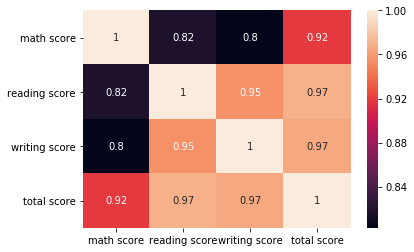

In [5]:
correlation = ds[["math score", "reading score", "writing score", "total score"]].corr()
sns.heatmap(correlation, annot = True)

There is a stronger correlation between reading and writing than math. This might be explained by the idea that reading and writing are both creative subjects. On the other hand, math is inherently more logical, and thus proficiency in reading/writing does not directly transfer to proficiency in mathematics. However, there is still a strong correlation which could be accounted for by the fact that students that perform well on one subject will perform well on all subjects because of effect studying habits or higher intellectual capacities. The collinearity of these features are expected- of course the total score feature is highly dependent on the math score, reading score, and writing score. 

Text(0.5,1,'Distribution of Writing Scores')

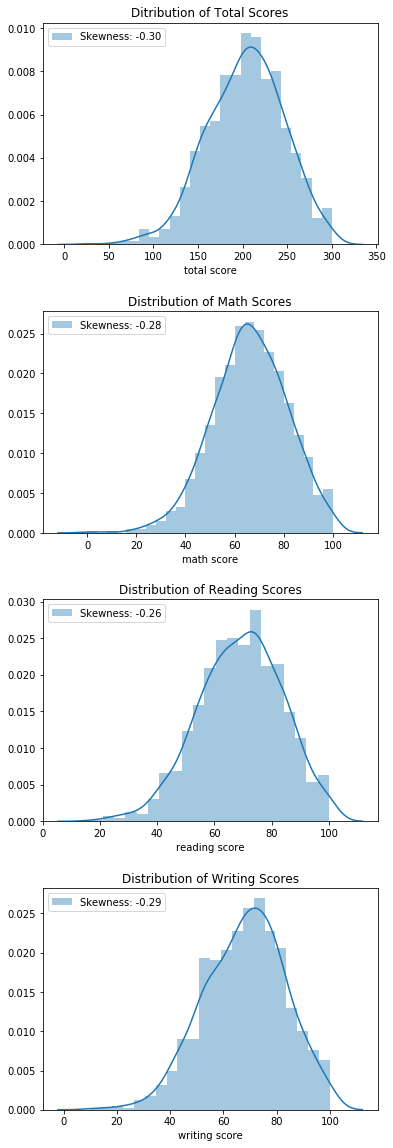

In [6]:
#Plot the rest of the scores too. 

fig, axes = plt.subplots(4,1)
fig.set_figheight(20)
fig.subplots_adjust(hspace=.3)
g_total = sns.distplot( label = "Skewness: %.2f"%ds["total score"].skew(), a = ds["total score"], ax = axes[0])
g_total.legend()
g_total.set_title("Ditribution of Total Scores")
g_math = sns.distplot( label = "Skewness: %.2f"%ds["math score"].skew(), a = ds["math score"], ax = axes[1])
g_math.legend()
g_math.set_title("Distribution of Math Scores")
g_reading = sns.distplot( label = "Skewness: %.2f"%ds["reading score"].skew(), a = ds["reading score"], ax = axes[2])
g_reading.legend()
g_reading.set_title("Distribution of Reading Scores")
g_writing = sns.distplot( label = "Skewness: %.2f"%ds["writing score"].skew(), a = ds["writing score"], ax = axes[3])
g_writing.legend()
g_writing.set_title("Distribution of Writing Scores")

The distributions of the total score, math score, reading score and writing score features are normal. We have Gaussian distributions for all score features, which implies that the students were given a fair exam. Intuitively, too easy of a test would have resulted in right-skewed distributions, with the means of the scores higher than the medians. Too difficult of a test would have lead to left-skewed distributions where the means were less than the medians. 

## Categorical Features

#### Categorical Variables are:
    1. gender
    2. Race
    3. Parental level of education
    4. Lunch
    5. Test preparation Course

#### Race/Ethnicity

In [7]:
#Obtain relative frequenices of each racial/ethnic group
maskA = ds["race/ethnicity"] == "group A"
maskB = ds["race/ethnicity"] == "group B"
maskC = ds["race/ethnicity"] == "group C"
maskD = ds["race/ethnicity"] == "group D"
maskE = ds["race/ethnicity"] == "group E"
percentages = []
percentages.append(len(ds.loc[maskA, :])/ len(ds))
percentages.append(len(ds.loc[maskB, :])/ len(ds))
percentages.append(len(ds.loc[maskC, :])/ len(ds))
percentages.append(len(ds.loc[maskD, :])/ len(ds))
percentages.append(len(ds.loc[maskE, :])/ len(ds))
percentages = [round(i * 100, 2) for i in percentages]

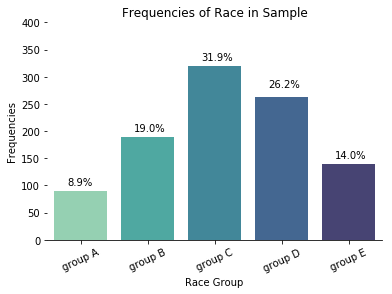

In [8]:
g = sns.countplot(x = "race/ethnicity", data = ds, 
                  palette = sns.color_palette("mako_r", 6), 
                  order = ["group A", "group B", "group C", "group D", "group E"] 
                 )
plt.xticks(rotation = 25)
plt.ylabel("Frequencies")
plt.xlabel("Race Group")
plt.title("Frequencies of Race in Sample")
plt.ylim(0, 400)

plt.text(-.2, 100, str(percentages[0]) + "%")
plt.text(.8, 200, str(percentages[1]) + "%")
plt.text(1.8, 330, str(percentages[2]) + "%")
plt.text(2.8, 280, str(percentages[3]) + "%")
plt.text(3.8, 150, str(percentages[4]) + "%")
sns.despine(left = True)

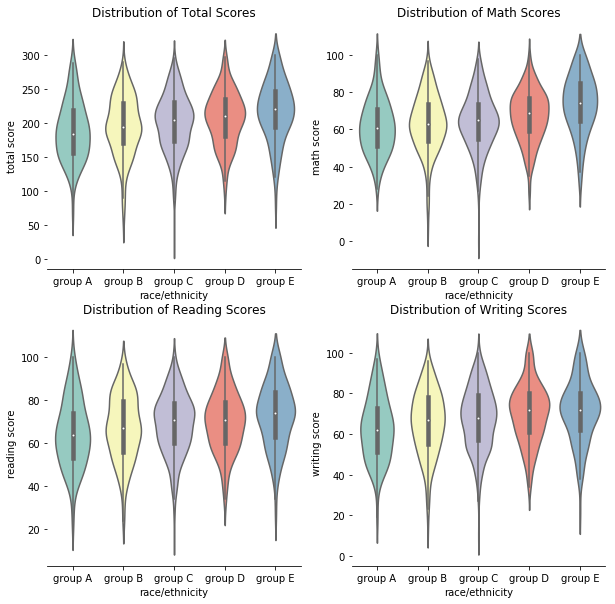

In [9]:
fig, axes = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(10)
order = ["group A", "group B", "group C", "group D", "group E"]
g_total = sns.violinplot(x = "race/ethnicity", y = "total score", palette = "Set3", data = ds, ax = axes[0][0], order = order)
g_math = sns.violinplot(x = "race/ethnicity", y ="math score", palette = "Set3", data = ds, ax = axes[0,1], order = order)
g_reading = sns.violinplot(x = "race/ethnicity", y ="reading score", palette = "Set3", data = ds, ax = axes[1,0], order = order)
g_writing = sns.violinplot(x = "race/ethnicity", y ="writing score", palette = "Set3", data = ds, ax = axes[1,1],order = order )
g_total.set_title("Distribution of Total Scores")
g_math.set_title("Distribution of Math Scores")
g_reading.set_title("Distribution of Reading Scores")
g_writing.set_title("Distribution of Writing Scores")
sns.despine(left = True)

There appears to be an association between the race/ethnicity and the score distributions. In particular, in traversing down the letters of the alphabet from A to E, the mean scores of the racial groups tend to rise. 
Let's perform an analysis of variance to check if there are any statistical significant differences between the total scores of different races. 

The means that we have here are descriptive statistics, and thus the difference in means is also descriptive. We need to perform some sort of ANOVA/statistical test to see if it's an inferential statistic. 

Throughout the notebook, the common significance level of 0.05 will be used. For all hypothesis testing, the possibility of making a type 1 error (rejecting the null hypothesis incorrectly) will be 5%. 

In [10]:
#ANOVA test to quanitfiy our findings.
subsample_A = ds.loc[ds["race/ethnicity"] == "group A", "total score"]
subsample_B = ds.loc[ds["race/ethnicity"] == "group B", "total score"]
subsample_C = ds.loc[ds["race/ethnicity"] == "group C", "total score"]
subsample_D = ds.loc[ds["race/ethnicity"] == "group D", "total score"]
subsample_E = ds.loc[ds["race/ethnicity"] == "group E", "total score"]

f_stats = stats.f_oneway(subsample_A, subsample_B, subsample_C, subsample_D, subsample_E)
print("The F-statistic is: " + str(f_stats[0]))
print("The p-value is: " + str(f_stats[1]))

The F-statistic is: 9.09605231339089
The p-value is: 3.2258693161040875e-07


In Analysis of Variance testing, the null hypothesis is first assumed to be true. Under this assumption, many F-statistics (ratios of variances) are calculated with many different samples and plotted on the F-distribution with appropriate degrees of freedom. In this case, the F-statistic is 9.1 with a p-value of 3.22e-07 which is nearly 0. The p-value is the percentage of type 1 error we would have to worry about if we were to reject the null hypothesis in favor of the alternate hypothesis. In other words, it is the percentage that we wrongly reject the null hypothesis when we shouldn't. According to the F-distribution calculated by scipy package's f_oneway function, under the assumption that the total score feature is independent of race/ethnicity feature, the percentage of obtaining an F-statistic of at least 9.1 is equal to or less than 3.22e-05%. 

Because the p-value is much lower than the significance level of 0.05 there is a statistically significant difference between the populations of at least one of the labels in the race/ethnicity categorical feature. 

However it is worthwhile to note that we have a very large sample size which gives us a large amount of statistical power, so that the ANOVA will only detect that there is some sort of difference, not how big this difference is. For example, with enough data points, ANOVA will tell us that means that differ by 0.001 units are statistically different. In practicality we know that this difference is miniscule. Since we have a fairly large dataset of 1000 observations, we should be wary of this.  With a large enough sample size, we obtain a statistically significant p-value but the differences between the performances of each group might be impractical (practically insignificant). Furthermore, ANOVA states only that there is some difference in the population means, but does not specify where this difference is. 

We can find an effect size or perform a post-hoc test to better describe the diffence in population means of the total scores split by different racial/ethnic groups.  
The effect size calculated by Eta^2 will be very small due to the presence of a lot of data making it hard to interpret. The Tukey post-hoc test would be more effective in showing the differences in total scores of the different racial/ethnic groups.

In [11]:
#Perform the Tukey post-hoc test to see where the actual mean differences are. 

In [12]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

mc = MultiComparison(ds['total score'], ds['race/ethnicity'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper  reject
-----------------------------------------------
group A group B  7.4277  -7.3486 22.2041 False 
group A group C 12.4175  -1.3729 26.2079 False 
group A group D 18.5606   4.4468 32.6745  True 
group A group E 29.2796  13.6842  44.875  True 
group B group C  4.9897  -5.5523 15.5317 False 
group B group D 11.1329   0.1712 22.0946  True 
group B group E 21.8519   9.0388  34.665  True 
group C group D  6.1432  -3.4482 15.7345 False 
group C group E 16.8622   5.1999 28.5245  True 
group D group E  10.719  -1.3241  22.762 False 
-----------------------------------------------
['group A' 'group B' 'group C' 'group D' 'group E']


We are interested in:
- group A group D 18.5606   4.4468 32.6745  True 
- group A group E 29.2796  13.6842  44.875  True 
- group B group D 11.1329   0.1712 22.0946  True 
- group B group E 21.8519   9.0388  34.665  True
- group C group E 16.8622   5.1999 28.5245  True

"Honestly" significant differences (HSD) appear between the pairwise mean differences of group A with groups D and E, group B with groups D and E, and finally group C with group E. This makes logical sense with the violinplot of distributions we graphed above. Tukey's test would reject the null hypothesis that the population means of these groups are equal, because the pairwise mean differences are greater than the Honestly Significant Difference associated with the data and computed by the statsmodels function. Note that group C only has a statistically significant difference with one out of 4 groups - group E. Group C lands in the middle of the total score distributions shown above by the distribution plot.

#### Parental level of Education

In [13]:
percentages = []
x = Counter(ds["parental level of education"])
percentages.append(x["some high school"])
percentages.append(x["high school"])
percentages.append(x["some college"])
percentages.append(x["associate's degree"])
percentages.append(x["bachelor's degree"])
percentages.append(x["master's degree"])
percentages = [round((i/1000) * 100, 2) for i in percentages]

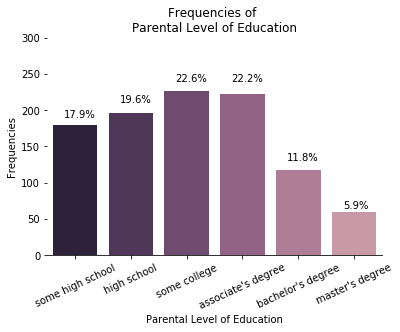

In [14]:
order = ["some high school",'high school','some college',"associate's degree","bachelor's degree", "master's degree"]
g = sns.countplot(x = "parental level of education", data = ds, palette = sns.cubehelix_palette(8, reverse = True), 
                  order = order)
plt.xticks(rotation = 25)
plt.ylabel("Frequencies")
plt.xlabel("Parental Level of Education")
plt.ylim(0, 300)
plt.title("Frequencies of \nParental Level of Education")
plt.text(-.2, 190, str(percentages[0]) + "%")
plt.text(.8, 210, str(percentages[1]) + "%")
plt.text(1.8, 240, str(percentages[2]) + "%")
plt.text(2.8, 240, str(percentages[3]) + "%")
plt.text(3.8, 130, str(percentages[4]) + "%")
plt.text(4.8, 65, str(percentages[5]) + "%")
sns.despine(left = True)

- 37.5% of our sample are students with parents that do not have some college education.
- 62.5% of our sample are students with parents that have at least some college education.

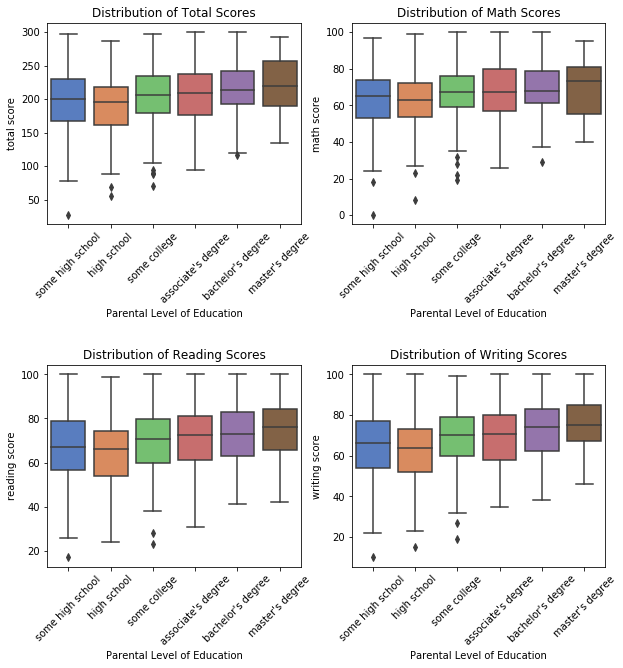

In [15]:
fig, axes = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(10)
g_total = sns.boxplot(x = "parental level of education", y = "total score", palette = "muted", data = ds, ax = axes[0][0], order = order)
g_math = sns.boxplot(x = "parental level of education", y ="math score", palette = "muted", data = ds, ax = axes[0,1], order = order)
g_reading = sns.boxplot(x = "parental level of education", y ="reading score", palette = "muted", data = ds, ax = axes[1,0], order = order)
g_writing = sns.boxplot(x = "parental level of education", y ="writing score", palette = "muted", data = ds, ax = axes[1,1],order = order )
g_total.set_title("Distribution of Total Scores")
g_math.set_title("Distribution of Math Scores")
g_reading.set_title("Distribution of Reading Scores")
g_writing.set_title("Distribution of Writing Scores")

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.xlabel("Parental Level of Education")
    
fig.subplots_adjust(hspace=.7)

In [16]:
#To avoid increasing type 1 errors using multiple t-tests, we should use ANOVA. 

subsample_some_high_school = ds.loc[ds["parental level of education"] == "some high school", "total score"]
subsample_high_school = ds.loc[ds["parental level of education"] == "high school", "total score"]
subsample_some_college = ds.loc[ds["parental level of education"] == "some college", "total score"]
subsample_associates = ds.loc[ds["parental level of education"] == "associate's degree", "total score"]
subsample_bachelors = ds.loc[ds["parental level of education"] == "bachelor's degree", "total score"]
subsample_masters = ds.loc[ds["parental level of education"] == "master's degree", "total score"]
f_stats = stats.f_oneway(subsample_some_high_school, 
                         subsample_high_school, subsample_some_college, 
                         subsample_associates, subsample_bachelors, 
                        subsample_masters)
print("The F-statistic is: " + str(f_stats[0]))
print("The p-value is: " + str(f_stats[1]))

The F-statistic is: 10.753146962336569
The p-value is: 4.3810464809431664e-10


Once again, it is useful to note that the more observations present, the lower the p-value will be. 

In [17]:
#Tukey post-hoc test
mc = MultiComparison(ds['total score'], ds['parental level of education'])
result = mc.tukeyhsd()
 
print(result)

          Multiple Comparison of Means - Tukey HSD,FWER=0.05          
      group1             group2      meandiff  lower    upper   reject
----------------------------------------------------------------------
associate's degree bachelor's degree  7.064   -6.5216  20.6495  False 
associate's degree    high school    -19.4164 -31.1043 -7.7284   True 
associate's degree  master's degree  12.0894  -5.3771  29.5559  False 
associate's degree    some college    -3.278  -14.5464  7.9904  False 
associate's degree  some high school -13.3832 -25.3623 -1.4041   True 
bachelor's degree     high school    -26.4804 -40.3751 -12.5856  True 
bachelor's degree   master's degree   5.0254  -13.9886 24.0395  False 
bachelor's degree     some college   -10.342  -23.8857  3.2018  False 
bachelor's degree   some high school -20.4472 -34.5877 -6.3066   True 
   high school      master's degree  31.5058  13.7977  49.2139   True 
   high school        some college   16.1384   4.499   27.7777   True 
   hig

We are interested in:
1. associate's degree    high school    -19.4164 -31.1043 -7.7284   True
2. associate's degree  some high school -13.3832 -25.3623 -1.4041   True 
3. bachelor's degree     high school    -26.4804 -40.3751 -12.5856  True
4. bachelor's degree   some high school -20.4472 -34.5877 -6.3066   True 
5. high school      master's degree  31.5058  13.7977  49.2139   True 
6. high school        some college   16.1384   4.499   27.7777   True
7. master's degree    some high school -25.4726 -43.3741  -7.571   True 

In summary, these seven comparisons encapsulate the idea that the statistically significant difference in means are basically between those of students with parents who have had some form of college education and those with parents who have not.

It would be interesting to see if there is an association between race/ethnicity and parental level of education. This can lead us to some insight on possible associations bewteen racial privilege and opportunity (demographics in the US). An appropriate test to use is the Chi-Square test of independence. We are testing if the feature parental level of education is independent of the race/ethinicty with a significance level of 0.05.

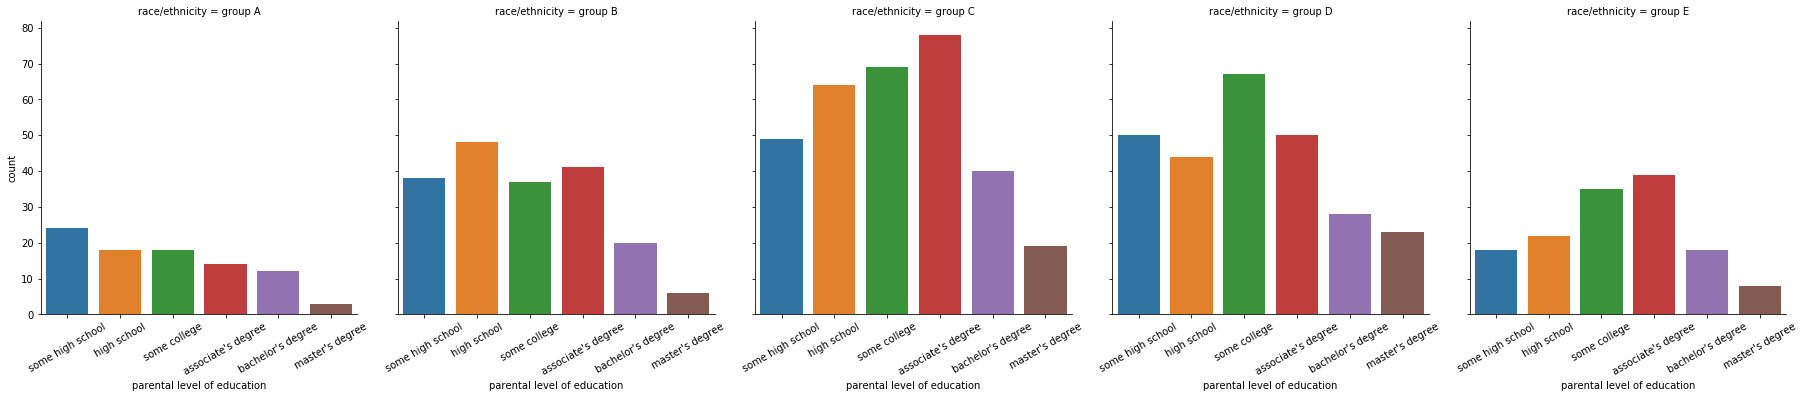

In [18]:
#It owuld be important to first visualize what we are expecting to see from the chi-square test. 
g= sns.catplot(x = "parental level of education", data = ds, col = "race/ethnicity", kind = "count", order = ["some high school", "high school", "some college", "associate's degree", "bachelor's degree", "master's degree"], col_order = ["group A", "group B", "group C", "group D", "group E"])
g.set_xticklabels(rotation=30)

In [19]:
from scipy.stats import chi2_contingency

In [20]:
cross_race_education = pd.crosstab(ds["race/ethnicity"], ds["parental level of education"], margins=True)
observations = cross_race_education.values
chi2, p, dof, ex = chi2_contingency(observations)
print("The chi-squared value is: %2f"%chi2)
print("The p-value is: %2f"%p)

The chi-squared value is: 29.458662
The p-value is: 0.493610


The p-value is not low enough to reject the null hypothesis that parental level of education is independent of race/ethnicity. We are not able to say that parental level of education is dependent on race/ethnicity.

#### Gender

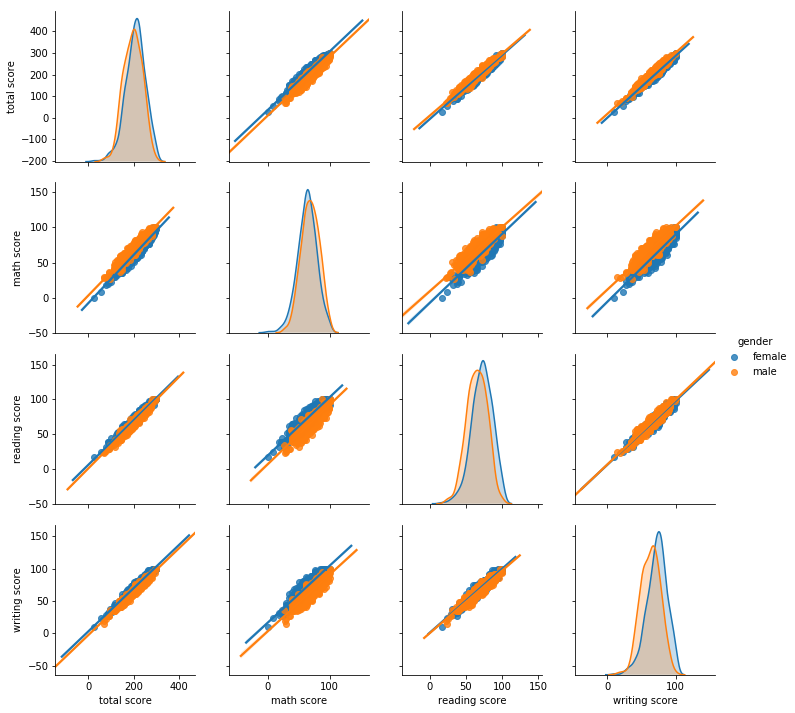

In [21]:
sns.pairplot(ds[["total score", "math score", "reading score", "writing score", "gender"]], hue = "gender", kind = "reg")

As shown by the earlier heatmap, there are obvious and clear correlations between the numeric scores. Nonetheless, it looks like males and females tend to perform better on different subjects. Let's explore this.

Text(0.5,1,'Distribution of \nWriting Scores')

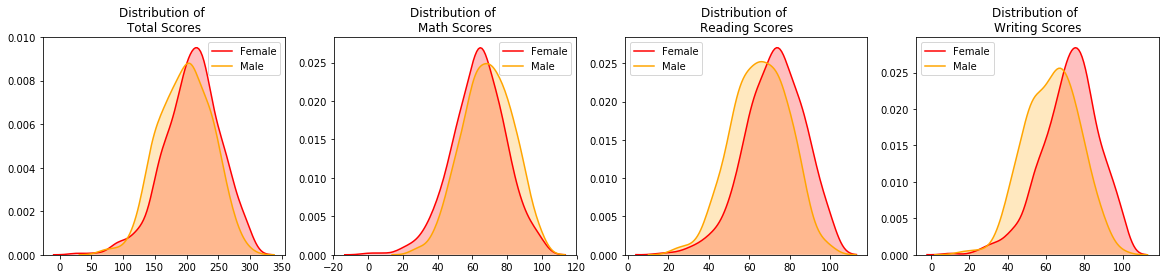

In [22]:
fig, axes = plt.subplots(1,4)
fig.set_figwidth(20)
mask_female = ds["gender"] == "female"
mask_male = ds["gender"] == "male"
g_total = sns.kdeplot(data = ds[mask_female]["total score"], label = "Female", shade = True, color = "red", ax = axes[0])
g_total = sns.kdeplot(data = ds[mask_male]["total score"], label = "Male", shade = True, color = "orange", ax = axes[0])
g_total.set_title("Distribution of \nTotal Scores")

g_math = sns.kdeplot(data = ds[mask_female]["math score"], label = "Female", shade = True, color = "red", ax = axes[1])
g_math = sns.kdeplot(data = ds[mask_male]["math score"], label = "Male", shade = True, color = "orange", ax = axes[1])
g_math.set_title("Distribution of \nMath Scores")

g_reading = sns.kdeplot(data = ds[mask_female]["reading score"], label = "Female", shade = True, color = "red", ax = axes[2])
g_reading = sns.kdeplot(data = ds[mask_male]["reading score"], label = "Male", shade = True, color = "orange", ax = axes[2])
g_reading.set_title("Distribution of \nReading Scores")

g_writing = sns.kdeplot(data = ds[mask_female]["writing score"], label = "Female", shade = True, color = "red", ax = axes[3])
g_writing = sns.kdeplot(data = ds[mask_male]["writing score"], label = "Male", shade = True, color = "orange", ax = axes[3])
g_writing.set_title("Distribution of \nWriting Scores")


Females have a higher scoring mean than males with respect to total score albiet these means are relatively close together. Notice that females tend to score higher on reading and writing, which are more creative disciplines while males have a higher mean in math scores, which is considered a logical discipline. This may hint at a fundamental difference in the way each gender is predisposed to think.

The t-test is used to confirm a statistically significant difference in the overall population means of two groups. What we want is to test if males and females belong to the same population, which also means that the samples we pull are from the same distribution of total scores. Thus, when we perform the t-test, we see if these two are subsamples of the same population (i.e. with the same mean). We will use a significance level of 0.05, for the type 1 error of the t-distribution.  
Note: The independent samples t-test assumes normality, independent samples, and homogeneity. 

In [23]:
#Perform t-test.
#We use a sample of 400 for adequate statistical power instead of using the entire subsamples for each gender.
#This tends to lower our critical value when n1 and n2 are large, such that any slight difference in mean 
#is described to be statiscally significant. 


#We actually used a sample of 400 for more statistical power, because we couldn't get a p-value low enough. 
male = ds.loc[ds["gender"] == "male", :].sample(300, random_state = 2)
female = ds.loc[ds["gender"] == "female", :].sample(300, random_state = 2)
results = stats.ttest_ind(male["total score"], female["total score"])
print("The calculated t-statistic is: " + str(results[0]))
print("The p-value is: " + str(results[1]))


The calculated t-statistic is: -2.4849706126594517
The p-value is: 0.013228562427613878


The magnitude of the calculated t-statistic of 2.485. The p-value associated with the t-statistic has a value of 0.0231 which is less than the significance level of 0.05, allowing for the conclusion that there is a statistical difference between the total scores of males and females. In particular, all else constant, females tend to have better overall scores on the exam.

In [24]:
#It's good to compare the amount of statistical power needed to achieve a p-value that's lower than the confidence level. \
#This would affect the amount of variance explained by the particular independent variable. 

In [25]:
#function adapted from https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python
from numpy import std, mean, sqrt
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)
print("Cohen's D is " + str(abs(cohen_d(male["total score"],female["total score"]))))


Cohen's D is 0.202897000894232


Cohen's D is the difference in mean expressed in units of the standard deviation. In general, we will use the Cohen's guideline (1988): 

| Cohen's D| Effect Interpretation| 
|:----|-------:  |
| 0.2| Small Effect| 
|0.5| Medium Effect|
|0.8|Large Effect|


The effect size of Cohen's D due to gender is 0.21. The 0.21 is interpreted as 21% of a standard deviation, with a pooled standard deviation using the formula: ![pic](http://www.polyu.edu.hk/mm/effectsizefaqs/formula/f2.jpg) From Cohen's guidelines, the effect size of 0.203 indicates that gender explains for a small variance in the total score (Zaiontz).

#### Lunch

It should suffice to the distributions of total scores based on the lunch feature. With intuition and common sense, it would be safe to infer that the distibutions we see will be common among the three subsets of scores (math, reading, and writing).  
We can imagine that the lunch feature is indicative, to some degree, of the financial standing of a particular student's family. Families that are less well-off tend to be on free/reduced lunch. We keep this in mind, as we observe trends. 

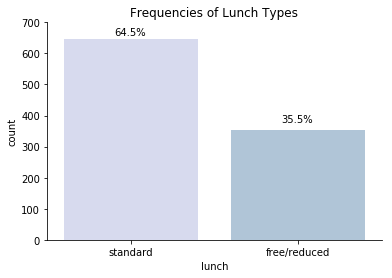

In [26]:
percentages = []
x = Counter(ds["lunch"])
percentages.append(x["standard"])
percentages.append(x["free/reduced"])
percentages = [round((i/1000) * 100, 2) for i in percentages]

sns.countplot(x = "lunch", data = ds, palette = sns.cubehelix_palette(8, start=1, rot=.75))
plt.title("Frequencies of Lunch Types")
plt.ylim(0,700)

plt.text(-.1, 660, str(percentages[0]) + '%')
plt.text(0.9, 380, str(percentages[1]) + '%')
sns.despine()

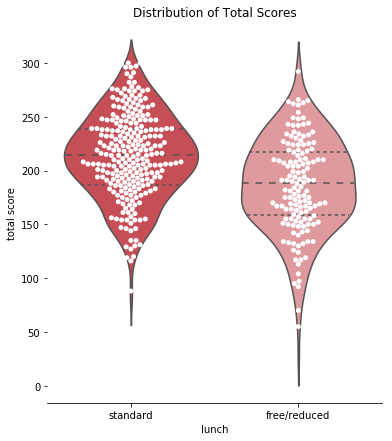

In [27]:
fig = plt.figure()
ax = sns.violinplot(x = "lunch", y = "total score", data =ds, inner = "quartile", palette = sns.diverging_palette(10, 220, sep=80, n=7))
fig.set_figheight(7)
plt.title("Distribution of Total Scores")
sns.despine(left = True)
#There's too many observations so let's just get a random sample of them and include the swarmplot.
sample = ds.sample(frac=0.40, replace=False)
ax = sns.swarmplot(x="lunch", y="total score", data=sample,
                    color="white", edgecolor="gray")

In [28]:
#Perform t-test

standard = ds.loc[ds["lunch"] == "standard", :].sample(20, random_state = 2)
free = ds.loc[ds["lunch"] == "free/reduced", :].sample(20, random_state = 2)
results = stats.ttest_ind(standard["total score"], free['total score'])
print("The t-statstic is: " + str(results[0]))
print("The p-value is: " + str(results[1]))

The t-statstic is: 2.340205730482105
The p-value is: 0.024625260428825235


Even with a smaller sample size of n1 = n2 = 20 (less statistical power), the calculated p-value of 0.0246 is still less than the significance level of 0.05. We conclude with confidence that there is a statistically significant difference between the total scores of students that have standard lunch and those that have free/reduced lunch. Namely, their populations do not have the same mean.  

In [29]:
print("Cohen's D is " + str(abs(cohen_d(standard["total score"],free["total score"]))))

Cohen's D is 0.7400380301701586


There is a medium to high effect size, which shows that the type of lunch plan a student has explains a relatively large variance in total score - 74% of a standard deviation. 

#### Test Preparation

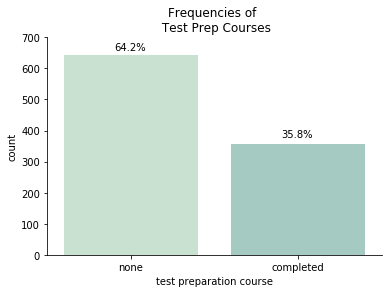

In [30]:
percentages = []
x = Counter(ds["test preparation course"])
percentages.append(x["none"])
percentages.append(x["completed"])
percentages = [round((i/1000) * 100, 2) for i in percentages]
sns.countplot(x = "test preparation course", data = ds, palette = sns.cubehelix_palette(8, start=1, rot=-.75))
plt.title("Frequencies of \n Test Prep Courses")
plt.ylim(0,700)

plt.text(-.1, 660, str(percentages[0]) + '%')
plt.text(0.9, 380, str(percentages[1]) + '%')
sns.despine()

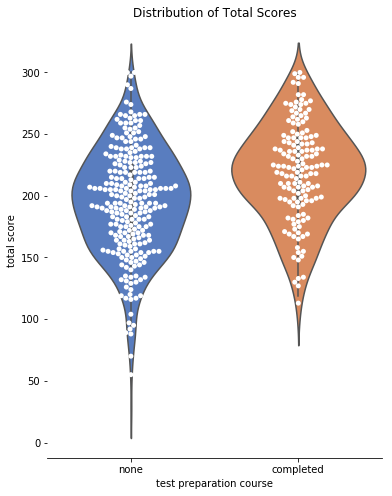

In [31]:
Counter(ds["test preparation course"])
fig = plt.figure() 
ax = sns.violinplot(x = "test preparation course", y = "total score", data = ds, palette = "muted")
fig.set_figheight(8)
plt.title("Distribution of Total Scores")
sns.despine(left = True)
ax = sns.swarmplot(x="test preparation course", y="total score", data=sample,
                    color="white", edgecolor="gray", order = ["none", "completed"])

As expected, students who completed test preparation scored higher than those who did not on average.

In [32]:
#Perform t-test
completed = ds.loc[ds["test preparation course"] == "completed", :].sample(60, random_state = 2)
none = ds.loc[ds["test preparation course"] == "none", :].sample(60, random_state = 2)
results = stats.ttest_ind(completed["total score"], none['total score'])
print("The t-statstic is: " + str(results[0]))
print("The p-value is: " + str(results[1]))

The t-statstic is: 2.411165788907827
The p-value is: 0.017444023178070266


The p-value of 0.01744 is low enough for us to reject the null hypothesis that the populations from which the susbsamples of students who completed test preparation and who did not complete test preparation have the same mean total score. This means that test preparation is not independent of total score. 


In [33]:
print("Cohen's D is " + str(abs(cohen_d(completed["total score"],none["total score"]))))

Cohen's D is 0.4402166308231855


With a sample size of n1 = n2 = 60 we obtain a Cohen's D of 0.44. Cohen's general guideline from earlier considers the completion of a test preparation course to have a small to medium effect on total score. If we were to calculate the effect size for a higher n, we would more closely approximate the population mean, and in doing so, Cohen's D increases to approximately 0.5 (this is heuristic). 

More interestingly, there might be an association between the type of lunch plan a student had and whether or not they completed a test preparation course. We could possibly explore the families' financial standings with these two features, as families who are not well-off might not have the means or resources to afford test preparation for their children. Perhaps we may be able to add a new feature based on these two features. 

In [34]:
mask_completed = ds["test preparation course"] == "completed"
mask_not_completed = ds["test preparation course"] == "none"

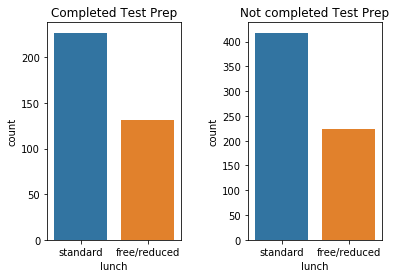

In [35]:
fig, axes = plt.subplots(1,2)
sns.countplot(x = "lunch", data = ds[mask_completed], ax = axes[0])
axes[0].set_title("Completed Test Prep")
sns.countplot(x ="lunch", data = ds[mask_not_completed], ax = axes[1])
axes[1].set_title("Not completed Test Prep")
fig.subplots_adjust(hspace=.7, wspace = .5)

It looks like the percentages are relatively similar, which means that whether a student is on free/reduced lunch does not indicate whether he/she has completed test preparation.  
Just to be sure, we will run the Chi-Square test of independence to compare the two categorical variables.

In [36]:
cross_table = pd.crosstab(ds.lunch, ds["test preparation course"], margins=True)
chi2, p, dof, ex = chi2_contingency(cross_table.values)
print("The chi-squared value is: %2f"%chi2)
print("The p-value is: %2f"%p)

The chi-squared value is: 0.290501
The p-value is: 0.990419


The p-value of 0.99 is greater than 0.05. We fail to reject the null hypothesis that these two categorical variables are independent. 

Lastly we ask: do different races/ethnicities of students tend to have different patterns of completing test preparation courses?

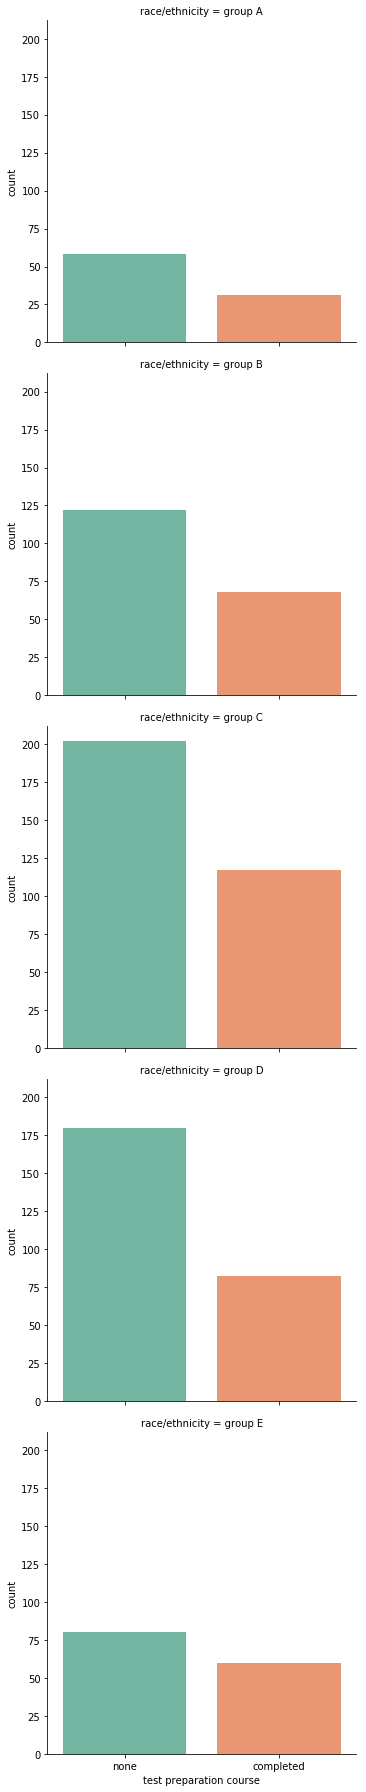

In [37]:
sns.catplot(x = "test preparation course", data = ds, row = "race/ethnicity", kind = "count", palette = "Set2", row_order = ["group A", "group B", "group C", "group D", "group E"])

In [38]:
#Chi-Square test of independence.
cross_race_testprep = pd.crosstab(ds["race/ethnicity"], ds["test preparation course"], margins=True)

In [39]:
observations = cross_race_testprep.values
chi2, p, dof, ex = chi2_contingency(observations)
print("The chi-squared value is: %2f"%chi2)
print("The p-value is: %2f"%p)

The chi-squared value is: 5.487515
The p-value is: 0.856328


The p-value is too large to accept the alternative hypothesis. We fail to reject the null hypothesis that race/ethnicity and test preparation course are independent. We cannot say that different race/ethnicity groups have different patterns of completing test preparation courses. 

## Feature Engineering

We can create some sort of feature that indicates the financial standing of a student's family. As we've mentioned before, the lunch feature is an important indicator of how well-off a family is. We can also imagine that students from poorer families are more likely to have parents with lower education, and may not have the means to take test preparation courses due to non-academic obligations (e.g. working a part time job, or not being able to afford a test preparation course). After observing the strong effect sizes that test preparation and lunch plan have on exam scores, it would be worthwhile to strengthen our data with a feature that captures the underlying financial implications of these features. Therefore, we'll use existing features to infer the financial standing of each student's family. Of course, this feature will not be perfect as there are expections to every rule. 

In [40]:
[Counter(ds["parental level of education"]), Counter(ds["lunch"]), Counter(ds["test preparation course"])]

[Counter({"bachelor's degree": 118,
          'some college': 226,
          "master's degree": 59,
          "associate's degree": 222,
          'high school': 196,
          'some high school': 179}),
 Counter({'standard': 645, 'free/reduced': 355}),
 Counter({'none': 642, 'completed': 358})]

Students who are on free/reduced lunch, did not complete a test preparation course, and has a parent that only has some level high school education, should be considered not-well off. Once again, it is important to note that there are exceptions to every rule and we will have to be cautious in our analysis.

In [41]:
mask_not_welloff= (ds["lunch"] == "free/reduced") & (ds["test preparation course"] == "none") & ((ds["parental level of education"] == "some high school") | (ds["parental level of education"] == "high school"))
indexes = np.where(mask_not_welloff)
indexes = indexes[0]

In [42]:
mask_not_welloff[indexes] = "not well off"
mask_welloff = mask_not_welloff == False
indexes_welloff = np.where(mask_welloff)[0]
mask_not_welloff[indexes_welloff] = "well off"
ds["financial"] = mask_not_welloff

In [43]:
ds.loc[ds["financial"] == "not well off"].head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,financial
9,female,group B,high school,free/reduced,none,38,60,50,148,not well off
17,female,group B,some high school,free/reduced,none,18,32,28,78,not well off
37,female,group D,some high school,free/reduced,none,50,64,59,173,not well off
55,female,group C,high school,free/reduced,none,33,41,43,117,not well off
59,female,group C,some high school,free/reduced,none,0,17,10,27,not well off


#### Visualizing the Financial Feature

In [44]:
Counter(ds["financial"])

Counter({'well off': 916, 'not well off': 84})

Text(0.5,1,'Distribution of Total Score\n vs Financial Standing')

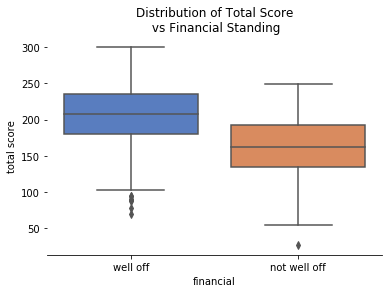

In [45]:
g = sns.boxplot(x = "financial", y = "total score", data = ds, palette = "muted")
sns.despine(left = True)
g.set_title("Distribution of Total Score\n vs Financial Standing")

One might be interested in whether the total score is dependent on the financial standing of a student's family. We will perform a t-test with significance level of 0.05, but we have to make sure that the assumptions of Student's t-test are met. Since there is a large difference in the populations in the different labels of the financial feature, it would be wise to check that the assumption of homogeneity is still met.

In [46]:
#Make sure that they have relatively equal standard deviations, since the population for well-off is significantly higher and ight affect that.
welloff = ds.loc[ds["financial"] == "well off", :].sample(80, random_state = 2)
notwelloff = ds.loc[ds["financial"] == "not well off", :].sample(80, random_state = 2)
print("The standard deviation for the total scores of students in well-off families is: %f" %std(welloff["total score"]))
print("The standard deviation for the total scores of students in families that are not well-off is: %f" %std(notwelloff["total score"]))



The standard deviation for the total scores of students in well-off families is: 42.798335
The standard deviation for the total scores of students in families that are not well-off is: 43.731194


The assumption of homogeneity is met so we can proceed with the t-test. 

In [47]:
#Perform t-test
results = stats.ttest_ind(welloff["total score"], notwelloff['total score'])
print("The t-statstic is: " + str(results[0]))
print("The p-value is: " + str(results[1]))

The t-statstic is: 5.554288766759923
The p-value is: 1.1562586143441206e-07


The independent samples t-test shows that there is a statistically significant difference in total scores between students who are well off and not well-off. Why might this be the case? As previously explained, we conjecture that students who are less privileged may have other non-academic responsibilites to support themselves and their families, taking away from their time and energy to study. 

In [48]:
print("Cohen's D is " + str(abs(cohen_d(welloff["total score"],notwelloff["total score"]))))

Cohen's D is 0.8782101642624542


The Cohen's D of 0.878 tells us that the effect the financial feature has on the total score is large. 

It would also be useful to group the observations using a categorical feature based on the students' performances on the exam. Let's discretize the scores into a "performance" feature. We can do this with the K-means clustering algorithm. 

# Finding Clusters and Correlations

In [49]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

### K-Means

We need to find our optimal K.

Text(0,0.5,'Inertia')

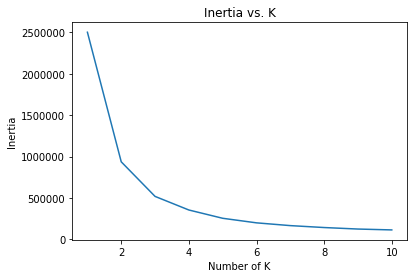

In [50]:
differing_k = []
for i in range(1,11):
    clusterer = KMeans(n_clusters = i, random_state = 42)
    x = clusterer.fit(ds[["total score", "math score", "reading score", "writing score"]])
    differing_k.append(x)

#Let's graph this....
k = [1,2,3,4,5,6,7,8,9,10]
inertia = []
for i in differing_k:
    inertia.append(i.inertia_)
#Plot a scatter plot with connecting lines.

ax = sns.lineplot(x = k, y = inertia, markers = True)
ax.set_title("Inertia vs. K")
ax.set_xlabel("Number of K")
ax.set_ylabel("Inertia")

The elbow plot of error vs K displays a diminishing return on inertia decrease after K = 5. So let's use k = 5 (split based on 5 groups). 

In [51]:
#We can make a k-means by the scores. Then we can analyze the different demographics of these groups. 
#Creating a kmeans based on the categorical variables does not make sense as the mean is not defined for categorical variables.
#One might use k-modes. 

kmeans = KMeans(n_clusters = 5, random_state = 42)
result = kmeans.fit(ds[["total score", "reading score", "writing score", "math score"]])
ds["Cluster1"] = result.labels_ 


Text(0.5,0,'Total Score')

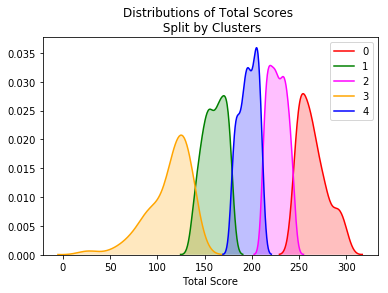

In [52]:
#We can visualize how k-means grouped our observations.

mask0 = ds["Cluster1"] == 0
mask1 = ds["Cluster1"] == 1
mask2 = ds["Cluster1"] == 2
mask3 = ds["Cluster1"] == 3
mask4 = ds["Cluster1"] == 4

sns.kdeplot(data = ds[mask0]["total score"], shade = True, color = "red", label = "0")
sns.kdeplot(data = ds[mask1]["total score"], shade = True, color = "green", label = "1")
sns.kdeplot(data = ds[mask2]["total score"], shade = True, color = "magenta", label = "2")
sns.kdeplot(data = ds[mask3]["total score"], shade = True, color = "orange", label = "3")
sns.kdeplot(data = ds[mask4]["total score"], shade = True, color = "blue", label = "4")
plt.title("Distributions of Total Scores \n Split by Clusters")
plt.xlabel("Total Score")


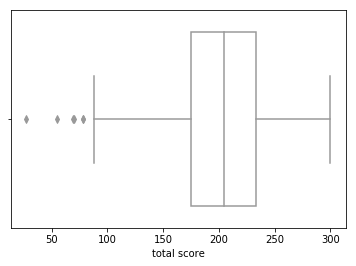

In [53]:
#This is the distribution of the overall total scores. 
sns.boxplot(x = "total score", data = ds, color = "white")

In [54]:
#Have a loook at the different clusters that k-means returned. 
score_summaries = {
    "cluster 3": ds[mask3]["total score"].describe(),
    "cluster 1": ds[mask1]["total score"].describe(),
    "cluster 4": ds[mask4]["total score"].describe(),
    "cluster 2": ds[mask2]["total score"].describe(),
    "cluster 0": ds[mask0]["total score"].describe()
}
score_summaries
#We can sort these by means (sorted with lowest to highest means as per the colored distribution graph two cells up)

{'cluster 3': count     58.000000
 mean     112.603448
 std       22.824225
 min       27.000000
 25%       98.500000
 50%      119.000000
 75%      130.000000
 max      136.000000
 Name: total score, dtype: float64, 'cluster 1': count    222.000000
 mean     160.382883
 std       11.520286
 min      137.000000
 25%      151.000000
 50%      161.000000
 75%      170.000000
 max      178.000000
 Name: total score, dtype: float64, 'cluster 4': count    281.000000
 mean     196.341637
 std        9.344823
 min      179.000000
 25%      189.000000
 50%      197.000000
 75%      205.000000
 max      211.000000
 Name: total score, dtype: float64, 'cluster 2': count    271.000000
 mean     227.143911
 std        9.295436
 min      212.000000
 25%      219.000000
 50%      227.000000
 75%      235.000000
 max      245.000000
 Name: total score, dtype: float64, 'cluster 0': count    168.000000
 mean     264.571429
 std       14.769515
 min      246.000000
 25%      252.000000
 50%      261.0000

In the context of exam performance: Cluster 3 < Cluster 1 < Cluster 4 < Cluster 2 < Cluster 0

We can use the clusters that k-means returned to make a new categorical feature which discretizes the scores based on performance.  
- Everyone in cluster 3 will be considered lowest-performing.
- Everyone in cluster 1 will be considered lower-performing.
- Everyone in cluster 4 will be considered medium -performing.
- Everyone in cluster 2 will be considered higher-performing.
- Everyone in cluster 0 will be considered highest-performing.

In [55]:
def change(x):
    if x == 3:
        return "lowest performing"
    elif x == 1:
        return "lower performing"
    elif x == 4:
        return "medium performing"
    elif x == 2:
        return "higher performing"
    else:
        return "highest performing"
    
ds['performance'] = ds['Cluster1'].map(change)


In [56]:
ds.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,financial,Cluster1,performance
0,female,group B,bachelor's degree,standard,none,72,72,74,218,well off,2,higher performing
1,female,group C,some college,standard,completed,69,90,88,247,well off,0,highest performing
2,female,group B,master's degree,standard,none,90,95,93,278,well off,0,highest performing
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,well off,1,lower performing
4,male,group C,some college,standard,none,76,78,75,229,well off,2,higher performing


In [57]:
Counter(ds["performance"])

Counter({'higher performing': 271,
         'highest performing': 168,
         'lower performing': 222,
         'lowest performing': 58,
         'medium performing': 281})

Let's visualize the demographics of each performance subgroup. 


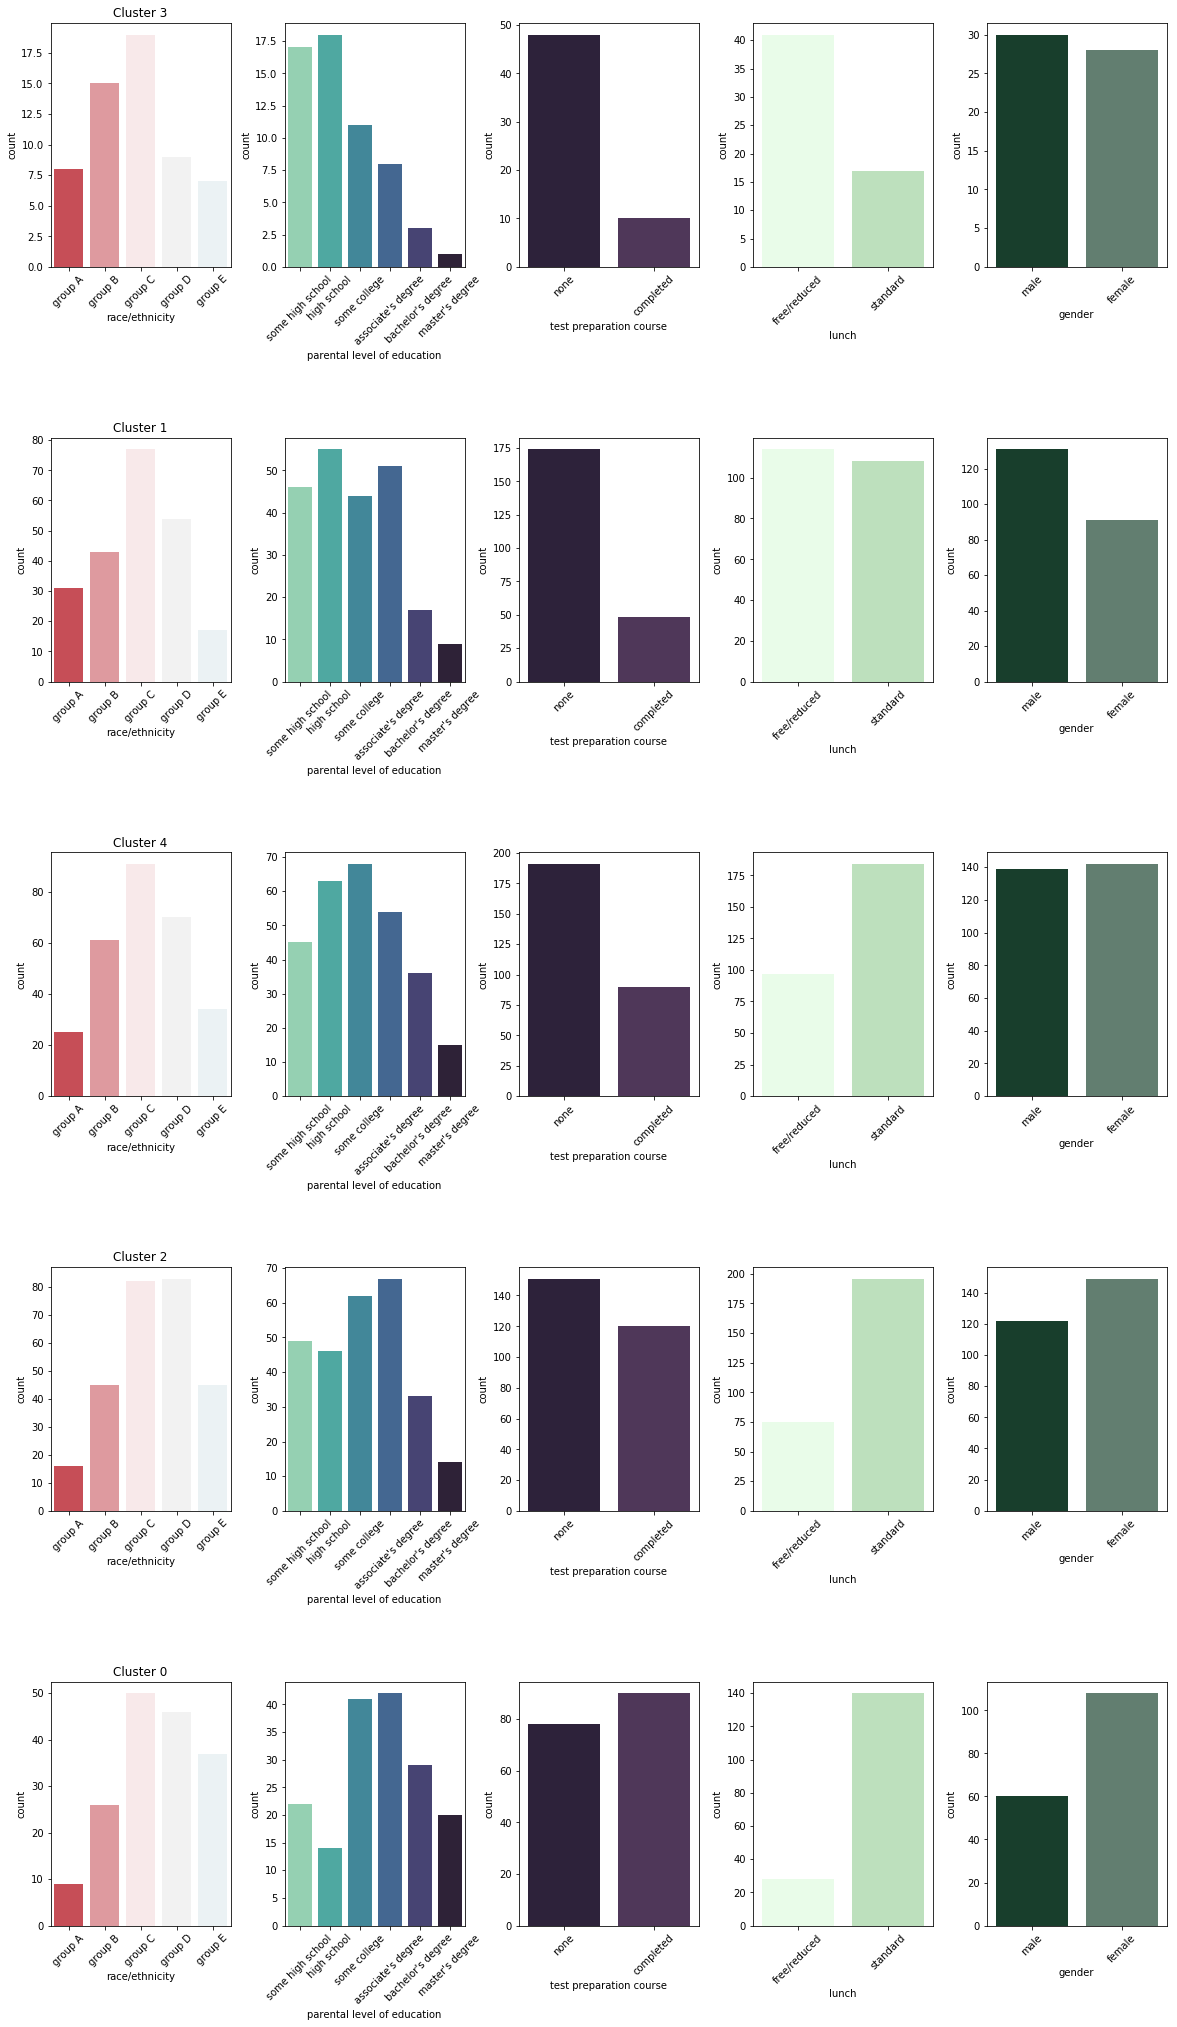

In [58]:
#For each cluster group, plot the parental education level, the race/ethnicity, the test preparation course, and the lunch.

order_race = ["group A", "group B", "group C", "group D", "group E"]
order_edu = ["some high school", "high school", "some college", "associate's degree", "bachelor's degree", "master's degree"]
order_test = ["none", "completed"]
order_lunch = ["free/reduced", "standard"]
order_gender = ["male", "female"]
#let's plot the countplots for each cluster
fig, axes = plt.subplots(5,5)
sns.countplot(x = ds.loc[ds["Cluster1"] == 3, "race/ethnicity"], ax = axes[0][0], palette = sns.diverging_palette(10, 220, sep=80, n=7), order = order_race)
sns.countplot(x = ds.loc[ds["Cluster1"] == 1, "race/ethnicity"], ax = axes[1][0], palette = sns.diverging_palette(10, 220, sep=80, n=7), order = order_race)
sns.countplot(x = ds.loc[ds["Cluster1"] == 4, "race/ethnicity"], ax = axes[2][0], palette = sns.diverging_palette(10, 220, sep=80, n=7), order = order_race)
sns.countplot(x = ds.loc[ds["Cluster1"] == 2, "race/ethnicity"], ax = axes[3][0], palette = sns.diverging_palette(10, 220, sep=80, n=7), order = order_race)
sns.countplot(x = ds.loc[ds["Cluster1"] == 0, "race/ethnicity"], ax = axes[4][0], palette = sns.diverging_palette(10, 220, sep=80, n=7), order = order_race)

sns.countplot(x = ds.loc[ds["Cluster1"] == 3, "parental level of education"], ax = axes[0][1], palette = sns.color_palette("mako_r", 6), order = order_edu)
sns.countplot(x = ds.loc[ds["Cluster1"] == 1, "parental level of education"], ax = axes[1][1], palette = sns.color_palette("mako_r", 6), order = order_edu)
sns.countplot(x = ds.loc[ds["Cluster1"] == 4, "parental level of education"], ax = axes[2][1], palette = sns.color_palette("mako_r", 6), order = order_edu)
sns.countplot(x = ds.loc[ds["Cluster1"] == 2, "parental level of education"], ax = axes[3][1], palette = sns.color_palette("mako_r", 6), order = order_edu)
sns.countplot(x = ds.loc[ds["Cluster1"] == 0, "parental level of education"], ax = axes[4][1], palette = sns.color_palette("mako_r", 6), order = order_edu)

sns.countplot(x = ds.loc[ds["Cluster1"] == 3, "test preparation course"], ax = axes[0][2], palette = sns.cubehelix_palette(8, reverse = True), order = order_test)
sns.countplot(x = ds.loc[ds["Cluster1"] == 1, "test preparation course"], ax = axes[1][2], palette = sns.cubehelix_palette(8, reverse = True), order = order_test)
sns.countplot(x = ds.loc[ds["Cluster1"] == 4, "test preparation course"], ax = axes[2][2], palette = sns.cubehelix_palette(8, reverse = True), order = order_test)
sns.countplot(x = ds.loc[ds["Cluster1"] == 2, "test preparation course"], ax = axes[3][2], palette = sns.cubehelix_palette(8, reverse = True), order = order_test)
sns.countplot(x = ds.loc[ds["Cluster1"] == 0, "test preparation course"], ax = axes[4][2], palette = sns.cubehelix_palette(8, reverse = True), order = order_test)


sns.countplot(x = ds.loc[ds["Cluster1"] == 3, "lunch"], ax = axes[0][3], palette = sns.light_palette("green"), order = order_lunch)
sns.countplot(x = ds.loc[ds["Cluster1"] == 1, "lunch"], ax = axes[1][3], palette = sns.light_palette("green"), order = order_lunch)
sns.countplot(x = ds.loc[ds["Cluster1"] == 4, "lunch"], ax = axes[2][3], palette = sns.light_palette("green"), order = order_lunch)
sns.countplot(x = ds.loc[ds["Cluster1"] == 2, "lunch"], ax = axes[3][3], palette = sns.light_palette("green"), order = order_lunch)
sns.countplot(x = ds.loc[ds["Cluster1"] == 0, "lunch"], ax = axes[4][3], palette = sns.light_palette("green"), order = order_lunch)

sns.countplot(x = ds.loc[ds["Cluster1"] == 3, "gender"], ax = axes[0][4], palette = sns.diverging_palette(145, 280, s=85, l=25, n=7), order = order_gender)
sns.countplot(x = ds.loc[ds["Cluster1"] == 1, "gender"], ax = axes[1][4], palette = sns.diverging_palette(145, 280, s=85, l=25, n=7), order = order_gender)
sns.countplot(x = ds.loc[ds["Cluster1"] == 4, "gender"], ax = axes[2][4], palette = sns.diverging_palette(145, 280, s=85, l=25, n=7), order = order_gender)
sns.countplot(x = ds.loc[ds["Cluster1"] == 2, "gender"], ax = axes[3][4], palette = sns.diverging_palette(145, 280, s=85, l=25, n=7), order = order_gender)
sns.countplot(x = ds.loc[ds["Cluster1"] == 0, "gender"], ax = axes[4][4], palette = sns.diverging_palette(145, 280, s=85, l=25, n=7), order = order_gender)

fig.set_figheight(35)
fig.set_figwidth(20)
fig.subplots_adjust(hspace=.7, wspace = .3)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
clusters = [3,1,4,2,0]   
for i in range(0, 5):
    axes[i][0].set_title("Cluster " + str(clusters[i]) ) 


In light of higher-performing clusters, the ratio of female to male beings to rise, leading us to think that females  are often more likely than males to perform at higher levels. This may be due to different reasons- perhaps females are more comfortable in seeking help or are, in general, more academically focused. As we approach higher-performing groups, we can also see that the ratio of standard/free/reduced lunch begins to rise, indicating that students with standard lunch payments contribute to the overall positive growth of performance in exam score. We infer that students of wealthy families tend to do better. As aforementioned, this may because poorer students have other obligations. 
We observe the same trends in test preparation, parental level of education, and race. 

For race/ethnicity, we can see that groups D and E tend to have a higher percentages of presence in higher-performing groups. This could be due to the fact that groups D and E are either historically priviledged or have a culture that heavily emphasizes academics relative to the other groups of races.  

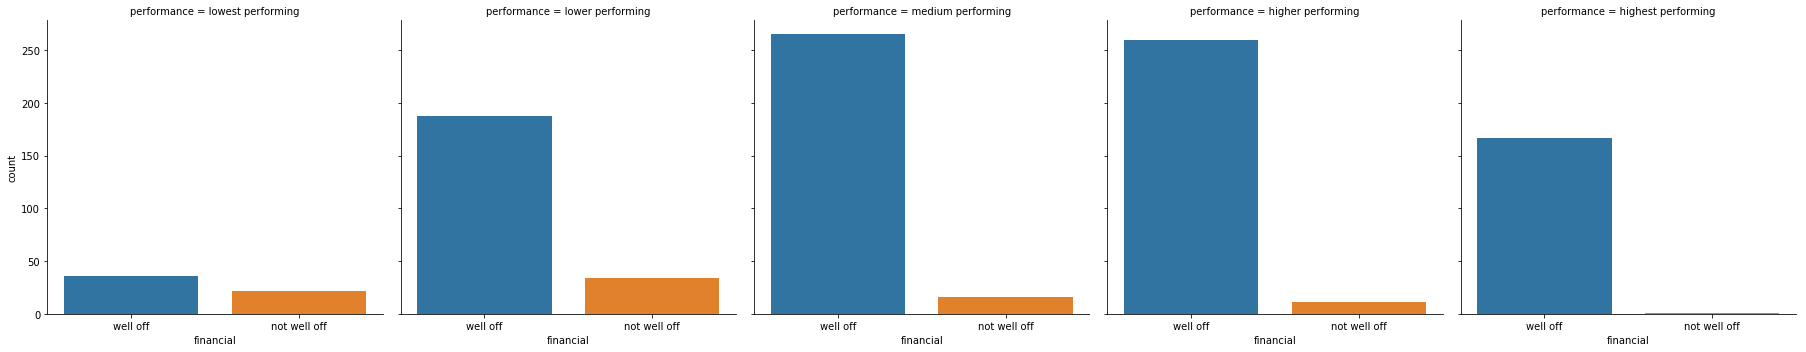

In [59]:
#Let's plot the financial feature vs the performance categories. 
sns.catplot(x = "financial", kind = "count", data = ds, col = "performance", col_order = ["lowest performing", "lower performing", "medium performing", "higher performing", "highest performing"])

As expected, high-performing clusters have low ratios of not well-off/ well off families. In other words, clusters in which students perform well are almost homogenously well-off. A Chi-Square test will confirm if this is the case. All of the assumptions of the Chi-Square test of independence are met. Chi-square is a non-parametric significance test. 

In [60]:
#Chi-Square test of independence.
cross_performance_financial = pd.crosstab(ds["performance"], ds["financial"], margins=True)
observations = cross_performance_financial.values
chi2, p, dof, ex = chi2_contingency(observations)
print("The chi-squared value is: %2f"%chi2)
print("The p-value is: %2f"%p)

The chi-squared value is: 102.145894
The p-value is: 0.000000


The extremely low p-value allows us to reject the null hypothesis that performance is independent of a student's family's financial standing. Now we'll use Cramer's V to calculate the effect size. 

In [61]:
def cramers_v(chi2, n, numcol, numrow):
    #evaluate the function
    numerator= sqrt(chi2)
    denominator = sqrt(n*(min(numcol, numrow)-1))
    return numerator/ denominator

In [62]:
#There are 5 unique values in performance and 2 in financial
effect_size = cramers_v(102.14, n =1000, numcol = 5, numrow = 2)
print("Cramer's V is: %f" %effect_size)

Cramer's V is: 0.319593


According to the Cohen's guideline (not listed here) for Cramer's V with degrees of freedom = 1, a Cramer's V of 0.319 is a medium effect (1988).  

These findings are interesting, but are also what we have discovered in feature analysis. We can employ the apriori algorithm to help us **quantify** some previous findings as well as spotting any other interesting combinations of demographics vs score performance. 

### Apriori

In [63]:
from apyori import apriori

In [64]:
ds.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,financial,Cluster1,performance
0,female,group B,bachelor's degree,standard,none,72,72,74,218,well off,2,higher performing
1,female,group C,some college,standard,completed,69,90,88,247,well off,0,highest performing
2,female,group B,master's degree,standard,none,90,95,93,278,well off,0,highest performing
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,well off,1,lower performing
4,male,group C,some college,standard,none,76,78,75,229,well off,2,higher performing


In [65]:
#Reorder the dataframe (put categorical data in the front columns)
ds = ds[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'financial', 'performance', 'math score', 'reading score', 'writing score', 'total score', 'Cluster1']]

In [66]:
#In order to simplifiy things, we'll drop the three features of parental level of education, lunch and test prep. 
#These features are encaptured in the financial feature. 
d_apriori = ds.drop(labels = ["parental level of education", "lunch", "test preparation course"], axis = 1)
d_apriori.head()

,gender,race/ethnicity,financial,performance,math score,reading score,writing score,total score,Cluster1
0,female,group B,well off,higher performing,72,72,74,218,2
1,female,group C,well off,highest performing,69,90,88,247,0
2,female,group B,well off,highest performing,90,95,93,278,0
3,male,group A,well off,lower performing,47,57,44,148,1
4,male,group C,well off,higher performing,76,78,75,229,2


The apriori algorithm implementation in the package apyori takes a list of lists. We will only use the categorical features gender, race/ethnicity, financial, and performance. 

In [67]:
observations = []
for i in range(0, 1000):
    observations.append([str(d_apriori.values[i,j]) for j in range(0, 4)])

In [68]:
#Set minimum support 0.015, or 15 observations out of 1000.
#Set minimum confidence of 20%.
#Set minimum lift of 1.2
rules = apriori(observations, min_support = 0.015, min_confidence = 0.2, min_lift = 1.2, min_length = 2 )


In [69]:
results = list(rules)
len(results)

44

We want to include rules that say something about the values of race/ethinicity, gender and performance. We can add it to an array and check if the rules contain at least one value in the list of interest. 

In [70]:
interesting_values = list(ds["race/ethnicity"].unique())
interesting_values.extend(list(ds["financial"].unique()))
interesting_values.extend(list(ds["gender"].unique()))
interesting_values

['group B',
 'group C',
 'group A',
 'group D',
 'group E',
 'well off',
 'not well off',
 'female',
 'male']

In [71]:
ds["race/ethnicity"].unique()

array(['group B', 'group C', 'group A', 'group D', 'group E'],
      dtype=object)

In [72]:
for i in range(0, len(results)):
    
    #If the itemset doesn't contain items from the list of interesting values, then exclude it. 
    count = 0
    for k in list(results[i][0]): #( this is the frozen set)
        if (interesting_values.count(k) == 0):
           pass
        else:
            count += 1
            

    if count != 0:
        base = str(set(results[i][2][0][0]))
        add = str(set(results[i][2][0][1]))
        print("Rule "+ str(i) + ": " + base + " -> " + add)
        print("Support: " + str(results[i][1]))
        print("Confidence: " + str(results[i][2][0][2]))
        print("Lift: " + str(results[i][2][0][3]))
        print("=====================================")
        
        #Then check if there are two ordered statistics...
        if len(results[i][2]) != 1:
            base = str(set(results[i][2][1][0]))
            add = str(set(results[i][2][1][1]))
            print("Rule "+ str(i) + ": " + base + " -> " + add)
            print("Support: " + str(results[i][1]))
            print("Confidence: " + str(results[i][2][1][2]))
            print("Lift: " + str(results[i][2][1][3]))
            print("=====================================") 
    else: 
        pass

Rule 0: {'female'} -> {'highest performing'}
Support: 0.108
Confidence: 0.2084942084942085
Lift: 1.2410369553226694
Rule 0: {'highest performing'} -> {'female'}
Support: 0.108
Confidence: 0.6428571428571428
Lift: 1.2410369553226694
Rule 1: {'group A'} -> {'lower performing'}
Support: 0.031
Confidence: 0.34831460674157305
Lift: 1.5689847150521308
Rule 2: {'group A'} -> {'male'}
Support: 0.053
Confidence: 0.5955056179775281
Lift: 1.2354888339782741
Rule 3: {'lowest performing'} -> {'group B'}
Support: 0.015
Confidence: 0.2586206896551724
Lift: 1.3611615245009072
Rule 4: {'group E'} -> {'highest performing'}
Support: 0.037
Confidence: 0.26428571428571423
Lift: 1.5731292517006799
Rule 4: {'highest performing'} -> {'group E'}
Support: 0.037
Confidence: 0.2202380952380952
Lift: 1.5731292517006799
Rule 5: {'lower performing'} -> {'male'}
Support: 0.131
Confidence: 0.5900900900900901
Lift: 1.2242532989420956
Rule 5: {'male'} -> {'lower performing'}
Support: 0.131
Confidence: 0.2717842323651452

---


We should parse through the rules outputted by apriori because they are long and some of them are difficult to interpret or don't add much meaning. The most strongest and most relevant rules have high lifts and confidence. Lift is defined as the following:  
###### *Lift = Confidence / Expected Confidence*

Intuitively, the lift is how much likelier we would find the occurence of the consequent *given* the antecendent. For example, if the rule {a, b} -> {c} has a lift of 2, then the probability of {c} is twice as much given {a,b} than the probability of just {c} itself. The higher the lift, the more we can be sure that the antecendent and the consequent are associated, or that the antecendent is more likely to imply the consequent. 

When looking at rules with antecedents that have a label from the performance feature, confidences around 0.20 are relatively insignificant. To establish a reference point, this is the case because if the performance feature were independent of anything, then the confidence of each value in the performance feature should be 20%. There are five values. Confidences substantially higher should be considered significant and worthy of interest. This is similar for the race/ethnicity feature as there are five groups. 

#### <u>Below are important rules with high lift:<u>

- Rule 6: {'not well off'} -> {'lower peforming'}
 - Support: 0.034
 - Confidence: 0.40476190476190477
 - Lift: 1.8232518232518233


- Rule 7: {'not well off'} -> {'lowest performing'}
 - Support: 0.022
 - Confidence: 0.26190476190476186
 - Lift: 4.515599343185549
 
 
- Rule 29: {'male', 'not well off'} -> {'lower peforming'}
 - Support: 0.019
 - Confidence: 0.5
 - Lift: 2.2522522522522523
 
 
 *Students with families that are not well-off/underprivileged tend to be low performers. We are 2.25 times more likely to find a student who is "lowest performing" if we look at students that are not well-off as opposed to the entire dataset. *  
 
 ================================================================================================
 
- Rule 1: {'group A'} -> {'lower peforming'}
 - Support: 0.031
 - Confidence: 0.34831460674157305
 - Lift: 1.5689847150521308


- Rule 18: {'male', 'group A'} -> {'lower peforming'}
 - Support: 0.02
 - Confidence: 0.37735849056603776
 - Lift: 1.6998130205677378


- Rule 22: {'male', 'group B'} -> {'lower peforming'}
 - Support: 0.028
 - Confidence: 0.32558139534883723
 - Lift: 1.4665828619316992

- Rule 19: {'well off', 'group A'} -> {'lower peforming'}
 - Support: 0.025
 - Confidence: 0.32894736842105265
 - Lift: 1.4817449027975345
 
 
- Rule 39: {'well off', 'male', 'group A'} -> {'lower peforming'}
 - Support: 0.016
 - Confidence: 0.35555555555555557
 - Lift: 1.6016016016016017


Students belonging to racial/ethnic groups A and B more likely to be low performers despite their financial statuses. Interestingly this is especially true for the males in those groups, though not exclusive of females. Rule 39 states that males in group A who are well-off have a 35.5% probability of being a student who had a "lower performance".  


 ================================================================================================
 
- Rule 26: {'male', 'higher performing'} -> {'group E'}
 - Support: 0.026
 - Confidence: 0.21311475409836064
 - Lift: 1.5222482435597187


- Rule 28: {'group E', 'well off'} -> {'highest performing'}
 - Support: 0.037
 - Confidence: 0.2803030303030303
 - Lift: 1.6684704184704182


- Rule 38: {'female', 'well off', 'group E'} -> {'highest performing'}
 - Support: 0.023
 - Confidence: 0.3709677419354839
 - Lift: 2.208141321044547

- Rule 14: {'female', 'group E'} -> {'highest performing'}
 - Support: 0.023
 - Confidence: 0.3333333333333333
 - Lift: 1.984126984126984
 
- Rule 4: {'group E'} -> {'highest performing'}
 - Support: 0.037
 - Confidence: 0.26428571428571423
 - Lift: 1.5731292517006799
 
*Both males and females in groups D and E are high-performers.*


#### <u> Below are rules with high confidence:<u>


- Rule 5: {'lower peforming'} -> {'male'}
 - Support: 0.131
 - Confidence: 0.5900900900900901
 - Lift: 1.2242532989420956


- Rule 30: {'lower peforming', 'well off'} -> {'male'}
 - Support: 0.112
 - Confidence: 0.5957446808510638
 - Lift: 1.235984815043701


- Rule 31: {'well off', 'lowest performing'} -> {'male'}
 - Support: 0.023
 - Confidence: 0.638888888888889
 - Lift: 1.3254956201014294
 
 
 *Given that a student has low performance there is a higher probability the student will be a male than a female. When the family is financially secure but the student is a low performer, the student is also more likely to be a male.*
 
 ================================================================================================
 
 
- Rule 0: {'highest performing'} -> {'female'}
 - Support: 0.108
 - Confidence: 0.6428571428571428
 - Lift: 1.2410369553226694


- Rule 8: {'higher performing', 'group B'} -> {'female'}
 - Support: 0.03
 - Confidence: 0.6666666666666666
 - Lift: 1.2870012870012868


- Rule 9: {'female', 'group B'} -> {'medium performing'}
 - Support: 0.036
 - Confidence: 0.34615384615384615
 - Lift: 1.2318642211880644


- Rule 10: {'higher performing', 'group C'} -> {'female'}
 - Support: 0.051
 - Confidence: 0.621951219512195
 - Lift: 1.2006780299463224


- Rule 11: {'highest performing', 'group C'} -> {'female'}
 - Support: 0.034
 - Confidence: 0.68
 - Lift: 1.3127413127413128


- Rule 12: {'female', 'group D'} -> {'higher performing'}
 - Support: 0.042
 - Confidence: 0.32558139534883723
 - Lift: 1.2014073629108384


- Rule 13: {'highest performing', 'group D'} -> {'female'}
 - Support: 0.03
 - Confidence: 0.6521739130434783
 - Lift: 1.2590229981534329


- Rule 15: {'highest performing', 'well off'} -> {'female'}
 - Support: 0.107
 - Confidence: 0.6407185628742514
 - Lift: 1.236908422537165
 
*Given that the student is a high performer, the student is more likely to be a female than a male. In groups that tend to be lower performers, females still outperform males (rules 8 and 9).*

In sum:

- *Low performance is highly associated with financial insecurity.*  
- *Males have a propensity to perform worse than females across all observed racial/ethnic groups.*  
- *Groups A and B are low-performing groups while groups D and E are high performing groups. *  
- *Males that are in low-performing racial/ethnic groups but are financially stable still have a tendency to perform worse.* 


From the previous feature analysis, we recognized that groups A and B are lower performers than groups C, D and E. Apriori gives us more statistics such as the support, confidence and lift. Rule 1 has shown that given a student is in group A, there is a 34.8% probability that he/she was "lower performing" on the exam. This is a 12.8% higher probability than if group A was independent of performance (32.8 - 20). We are 1.5 times more likely to find a student that was placed in the "lower performing" bracket on the exam than if we looked at the entire dataset. 

It is apparent that low performers are underprivileged, made obvious both by feature analysis, hypothesis testing and apriori. Immediately, one might reason that the students from groups A and B perform worse is perhaps because these two groups might be historically underprivileged. This motivates a Chi-Square test of independence between the features race/ethnicity and financial. 

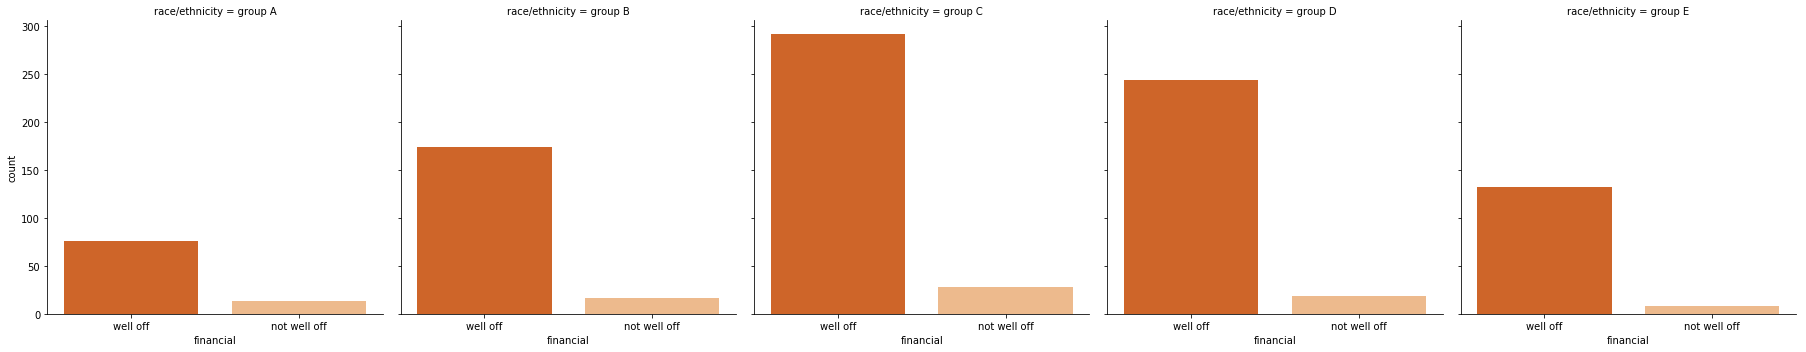

In [73]:
#Split the columns by race/ethnicity
sns.catplot(x = "financial", kind = "count", col = "race/ethnicity", data = ds, col_order = ["group A", "group B", "group C", "group D", "group E"], palette = "Oranges_r")

In [74]:
#Chi-Square test of independence.
cross_race_financial = pd.crosstab(ds["race/ethnicity"], ds["financial"], margins=True)
observations = cross_race_financial.values
chi2, p, dof, ex = chi2_contingency(observations)
print("The chi-squared value is: %2f"%chi2)
print("The p-value is: %2f"%p)

The chi-squared value is: 6.276390
The p-value is: 0.791532


The p-value is not lower than the common significance level of 0.05, thus we cannot reject the null hypothesis that the financial feature is independent of the race/ethnicity of a student's family. This leads us to say that groups A and B did not tend to perform worse on the exam scores because they are underprivileged races. Nor can we say that groups D and E perform well because they are privileged. This is also supported by Rule 19: {well off, group A} -> {lower peforming} where students in group A that are well-off are still low performing.

*One might also think that students with parents who have a high education are encouraged by their parents to perform better academically. Thus, it would follow that groups A and B may have because parents in these race groups have less schooling. However in the analysis of the parental level of education feature, the Chi-Square test of independence showed that we could not reject the null hypothesis where race/ethnicity and parental level of education were independent. 

We will have to conjecture that there is another explanation for the low performance tendencies in gropus A and B. It would be worthwhile for researchers to pursue this problem further, or might be explained for in the presence of additonal data. Perhaps different groups have dissimilar exam performance levels because of cultural behaviors and expectations or the amount of empahsis that each one places on academia. 

---

We are also shown from our Apriori model that specifically males from groups A who are well-off still performed poorly:

- Rule 18: {'male', 'group A'} -> {'lower peforming'}
 - Confidence: 0.37735849056603776
 - Lift: 1.6998130205677378
 
- Rule 19: {'well off', 'group A'} -> {'lower peforming'}
 - Confidence: 0.32894736842105265
 - Lift: 1.4817449027975345

- Rule 39: {'well off', 'male', 'group A'} -> {'lower peforming'}
 - Confidence: 0.35555555555555557
 - Lift: 1.6016016016016017
 
We are 1.6 times more likely to find a student in the "lower performance category" when we look at males in group A who are well off than in the whole dataset (from Rule 39). The rule also tells us about the confidence. The probability that these male students will be a low performer is 32.8%, which is substantially higher than the standard 20% considering there are five different performances. We know that this is not mainly due to financial issues. When looking at the graphs of distributions and the apriori rules, females from the same racial subgroup still perform much better when it comes to performance. So why are males in group A performing so much worse, when money is not an overall issue?  
Once again, given the amount and type of data we have, it would not be feasible to conclude why this is the case from limited data. However, this poses interesting questions for us to explore further outside of the scope of this notebook. It seems though, that males definitely have exam scores lower than females regardless of race/ethnicity and it may be a manifestation of American society's differing expectations on gender roles.

---

#### Notebook Summary:  
  In this notebook we have explored relationships between certain demographics of students and how they relate to the students' scores on a standardized exam. These demographics include race/ethnicity, gender, lunch payment, financial standing, parents' level of education and completion of test preparation course. 
  
*Key points that have been shown through analysis of the data are: *  
  - **Apriori:**
   1. Males that are in racial/ethnic group A but are financially stable still have a tendency to perform worse on exams. 
   
   
  - **Chi-Square Tests:**
   1. Race and the completion of test preparation are independent.   
   2. Race and the student's parent's level of education are independent.   
   3. Race and the student's financial standing are independent.   
   4. Student's financial standing and performance are dependent.
   
   
  - **Analysis of Variance:**
   1. The total scores of students have a statistically significant difference when comparing students that have parents with some level high school education and students that have parents with some level of college education. 
   2. The total scores of students have a statistically significant difference when looking at groups A and B compared with groups D and E.  Groups A and B are more likely to perform lower than groups D and E. 
   
   
  - **Student's t-test:**
   1. Gender has a small effect size with different means of total score. The means of the total scores of males and females differ by **20.3%** of a standard deviation with females performing better than males. 
   2. Lunch payment has a medium to large effect size with different means of total score. The means of the total scores of students who have standard lunch and students who have free/reduced lunch differ by **74%** of a standard deviation with students with standard lunch performing better than students with free/reduced lunch.    
   3. Test preparation has a medium effect size with different means of total score. The means of the total scores of students who have completed test preparation and students who have not differ by **44%** of a standard deviation with students who completed a test preparation course performing better than those who did not. 
   4. The financial standing of a family has a large effect size with different means of the total score. The means of the total scores of students in families that are well-off and students who are in families that are not well-off differ by **88%** of a standard deviation with students who are well-off performing better than those who are not.   
 
**Important Takeaways:** 
Comparing the listed Cohen's D's, the strongest effect size is associated with the financial standing of the student's families - an effect size of 88% of a standard deviation. This is larger than the difference in total score means when split by either gender, lunch payment and even test preparation course completion. This is interesting because there is more of a deviation in total scores when we split them by the financial standing of a family in comparison to the total scores when split by whether or not the students completed test preparation. In other words, out of all features that are in our dataset the financial standing of a student most determines whether or not the he/she will do well on the test.

This information can be used in practical applications where more academic programs target underprivileged students and their particular needs. It may be possible that in poorer communities, students have less opportunity and/or are less encouraged to perform well in school due to culture or other obligations. School districts in poorer communities can design campaigns to draw more attention towards academic emphasis and can implement specific opportunities tailored to the various schedules that underprivileged students require. These students may have to work part-time jobs in order to put food on the table and can not spend enough time as others who are more well-off studying or attending school. 

We see that in general, males perform worse than females on the exam. This is true for creative disciplines such as reading and writing. The opposite trend is seen for math: males perform better than females. Work can be done to engage different genders in areas where they tend to be weaker in.

Of course, not all of students' academic performance is solely accounted for by their financial state. Due to the complexity of students' lives, social relationships and various circumstances, many networks of intricate factors contribute to their performance on exams. This makes it impossible to create hard and fast rules that describes students and their academics. 


#### References:

Bowels, C. (2014, July 17). The Cohen's d Formula. Retrieved November 11, 2018, from 
https://trendingsideways.com/the-cohens-d-formula


Ellis, P. D. (2009, September 7). Effect Size Equations. Retrieved November 18, 2018, from  
> http://www.polyu.edu.hk/mm/effectsizefaqs/effect_size_equations2.html


Large Samples: Too Much of a Good Thing? (2012, June 4). Retrieved November 11, 2018, from  
> http://blog.minitab.com/blog/statistics-and-quality-data-analysis/large-samples-too-much-of-a-good-thing

Zaiontz, C. (n.d.). Effect Size for Chi-square Test. Retrieved November 17, 2018, from http://www.real-
> statistics.com/chi-square-and-f-distributions/effect-size-chi-square/